![Adversarial example](adversarial_example.png "Adversarial example")

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import torch.nn as nn

In [24]:
from utils import MnistData
from models import ModelManager, ModelType

In [25]:
model_loaded = ModelManager.get_trained(ModelType.MnistCnnPatt)

In [26]:
data = MnistData(True)

In [27]:
step_size = 50 / 255

In [28]:
benign_images, labels = data.get_training_batch(1000)

In [29]:
benign_images.requires_grad = True
if benign_images.grad is not None:
    benign_images.grad.zero_()
loss = nn.CrossEntropyLoss()(model_loaded(benign_images), labels)
loss.backward()
grad = benign_images.grad

In [30]:
altered_training_images = benign_images + step_size * grad.apply_(lambda x: 1 if x >= 0 else -1)

In [31]:
altered_training_images = altered_training_images.detach()
altered_training_images.apply_(lambda x: 1 if x> 1 else (0 if x < 0 else x))  # clip

tensor([[[[0.1961, 0.1961, 0.0000,  ..., 0.0000, 0.1961, 0.1961],
          [0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1961, 0.1961],
          [0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1961, 0.1961],
          ...,
          [0.1961, 0.1961, 0.1961,  ..., 0.0000, 0.0000, 0.1961],
          [0.0000, 0.0000, 0.0000,  ..., 0.1961, 0.1961, 0.1961],
          [0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1961, 0.1961]]],


        [[[0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1961, 0.1961],
          [0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1961, 0.1961],
          [0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1961, 0.1961],
          ...,
          [0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1961, 0.1961],
          [0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1961, 0.1961],
          [0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1961, 0.1961]]],


        [[[0.1961, 0.1961, 0.1961,  ..., 0.0000, 0.0000, 0.1961],
          [0.1961, 0.0000, 0.1961,  ..., 0.0000, 0.0000, 0.1961],
          [0.0000, 0.0000, 0.0000,  ..

In [32]:
possible_adversarials = MnistData.get_adversarials(model_loaded, benign_images, labels, altered_training_images)
len(possible_adversarials)

282

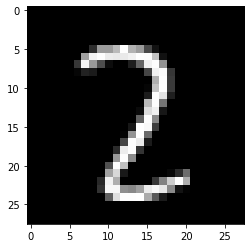

+++++


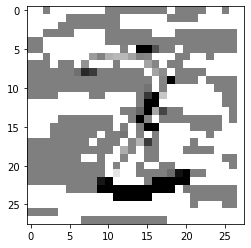

=====


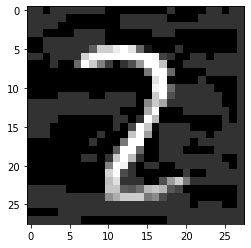

Label: 2, Prediction: 7, Confidence: 1.0
Original prediction: 2, Original confidence: 1.0


In [33]:
MnistData.show_adversarial(possible_adversarials, benign_images, altered_training_images, 0)